In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.distributions import MultivariateNormal
import copy
from copy import deepcopy
from tqdm import tqdm
import os
import pickle
import gc

# Ensure the device is GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model with update1 function for task 1.1 and update2 for task 1.2

In [19]:
class GPUProbabilisticLwP:
    def __init__(self, covariance_type='full', n_pseudo_samples=1000, swd_projections=1000):
        self.covariance_type = covariance_type
        self.n_pseudo_samples = n_pseudo_samples
        self.swd_projections = swd_projections
        self.prototypes = None
        self.covariances = None
        self.priors = None
        self.classes = None
        self.samples_in_each_class = None
        self.scaler = StandardScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    def _compute_covariance(self, X):
        """
        Compute the covariance matrix based on the specified type.
        """
        X = X.cpu().numpy()
        # print(f"X shape: {X.shape}")
        if X.shape[0] > X.shape[1]:
            cov = np.cov(X.T) + 1e-4 * np.eye(X.shape[1])
        else:
            # Use bias=True to handle degrees of freedom <= 0
            cov = np.cov(X.T, bias=True) + 1e-4 * np.eye(X.shape[1])
        cov = torch.tensor(cov, device=self.device)
        return cov

    def _generate_pseudo_dataset(self):
        print(f"Generating pseudo dataset with {self.n_pseudo_samples} samples...")
        n_features = self.prototypes[0].shape[0]
        pseudo_samples = torch.zeros((self.n_pseudo_samples, n_features), device=self.device)
        pseudo_labels = torch.zeros(self.n_pseudo_samples, device=self.device)

        start_idx = 0
        for idx, (prototype, covariance, prior) in enumerate(zip(self.prototypes,
                                                               self.covariances,
                                                               self.priors)):
            n_samples = int(self.n_pseudo_samples * prior.item())
            if idx == len(self.classes) - 1:
                n_samples = self.n_pseudo_samples - start_idx

            if n_samples > 0:

                prototype = prototype.float()  # or prototype.double() for consistency with Double tensors
                covariance = covariance.float()  # or covariance.double()
                dist = MultivariateNormal(prototype, covariance)
                samples = dist.sample((n_samples,))

                pseudo_samples[start_idx:start_idx + n_samples] = samples
                pseudo_labels[start_idx:start_idx + n_samples] = self.classes[idx]
                start_idx += n_samples

        return pseudo_samples, pseudo_labels

    def _compute_swd(self, P, Q, n_projections=100):
        min_samples = min(P.shape[0], Q.shape[0])
        if P.shape[0] > min_samples:
            idx = torch.randperm(P.shape[0], device=self.device)[:min_samples]
            P = P[idx]
        if Q.shape[0] > min_samples:
            idx = torch.randperm(Q.shape[0], device=self.device)[:min_samples]
            Q = Q[idx]

        dim = P.shape[1]
        projections = torch.randn(n_projections, dim, device=self.device)
        projections /= torch.norm(projections, dim=1, keepdim=True)

        P_projs = torch.mm(P, projections.T)
        Q_projs = torch.mm(Q, projections.T)

        P_projs, _ = torch.sort(P_projs, dim=0)
        Q_projs, _ = torch.sort(Q_projs, dim=0)

        swd = torch.mean(torch.sum((P_projs - Q_projs) ** 2, dim=0))
        return torch.sqrt(swd)

    def fit(self, X_train, y_train):
        if X_train is None or y_train is None:
            raise ValueError("Training data and labels cannot be None")

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32, device=self.device)
        y_train = torch.tensor(y_train, device=self.device)

        self.classes = torch.unique(y_train)
        n_samples = len(y_train)

        self.prototypes = []
        self.covariances = []
        self.priors = []
        self.samples_in_each_class = []

        for label in self.classes:
            mask = (y_train == label)
            class_samples = X_train_scaled[mask]
            self.samples_in_each_class.append(len(class_samples))
            if len(class_samples) > 0:
                prototype = torch.mean(class_samples, dim=0)
                self.prototypes.append(prototype)

                covariance = self._compute_covariance(class_samples)
                self.covariances.append(covariance)

                self.priors.append(torch.tensor(len(class_samples) / n_samples,
                                              device=self.device))

        self.prototypes = torch.stack(self.prototypes)
        self.covariances = torch.stack(self.covariances)
        self.priors = torch.stack(self.priors)

    def update1(self, X_target, confidence=0.9):
        if X_target is None:
            raise ValueError("Target data cannot be None")

        X_target_scaled = self.scaler.transform(X_target)
        X_target_scaled = torch.tensor(X_target_scaled, dtype=torch.float32, device=self.device)

        # predict the pseudo labels
        pseudo_labels = self.predict(X_target)
        pseudo_labels = torch.tensor(pseudo_labels, device=self.device)

        # filter out the samples with low confidence
        probas = self.predict_proba(X_target)
        max_probas, _ = torch.max(probas, dim=1)
        mask = (max_probas > confidence)
        X_target_filtered = X_target_scaled[mask]
        pseudo_labels_filtered = pseudo_labels[mask]

        print(f"size of filtered target samples: {len(X_target_filtered)}")

        old_sample_size = sum(self.samples_in_each_class)
        print(f"Old sample size: {old_sample_size}")

        # update the model
        for label in self.classes:
            # complete the update function here
            mask = (pseudo_labels_filtered == label)
            class_samples = X_target_filtered[mask]

            if len(class_samples) > 0:

                prototype = torch.mean(class_samples, dim=0)
                covariance = self._compute_covariance(class_samples)
                prior = torch.tensor(len(class_samples) / len(X_target_filtered), device=self.device)

                # Update the prototypes, covariances, and priors
                self.prototypes[label] = (self.samples_in_each_class[label] * self.prototypes[label] + len(class_samples) * prototype) / (self.samples_in_each_class[label] + len(class_samples))
                self.covariances[label] = (self.samples_in_each_class[label] * self.covariances[label] + len(class_samples) * covariance) / (self.samples_in_each_class[label] + len(class_samples))
                self.priors[label] = (self.samples_in_each_class[label] * self.priors[label] + len(class_samples) * prior) / (self.samples_in_each_class[label] + len(class_samples))

                self.samples_in_each_class[label] += len(class_samples)

        print(f"Updating model with {len(X_target)} target samples...")

    def update2(self, X_target, max_iterations=10, threshold=0.01):
        X_target_scaled = self.scaler.transform(X_target)
        X_target_scaled = torch.tensor(X_target_scaled, dtype=torch.float32, device=self.device)

        best_swd = float('inf')
        best_state = None

        for iteration in range(max_iterations):
            # Generate pseudo-dataset
            pseudo_samples, pseudo_labels = self._generate_pseudo_dataset()

            # Compute distribution alignment
            current_swd = self._compute_swd(X_target_scaled, pseudo_samples, self.swd_projections)
            print(f"Iteration {iteration + 1}: SWD = {current_swd}")

            # Track best state
            if current_swd < best_swd:
                best_swd = current_swd
                best_state = {
                    'prototypes': self.prototypes.clone(),
                    'covariances': self.covariances.clone(),
                    'priors': self.priors.clone()
                }

            # Early stopping condition
            if iteration > 0 and abs(current_swd - prev_swd) < threshold:
                break
            prev_swd = current_swd

            # Confident sample selection with more robust approach
            probas = self.predict_proba(X_target)
            confidence_mask = self._get_robust_confidence_mask(probas)

            if not torch.any(confidence_mask):
                break

            # Update distribution with more careful parameter mixing
            self._update_distribution(X_target_scaled, probas, confidence_mask)

        # Restore best state if final state is worse
        if best_state and best_swd < current_swd:
            self.prototypes = best_state['prototypes']
            self.covariances = best_state['covariances']
            self.priors = best_state['priors']

        return best_swd

    def _get_robust_confidence_mask(self, probas, confidence_threshold=0.9, entropy_threshold=0.5):
        # More robust confidence selection
        max_probs = torch.max(probas, dim=1)[0]
        entropies = -torch.sum(probas * torch.log(probas + 1e-10), dim=1)

        confidence_mask = (
            (max_probs > confidence_threshold)
            # & (entropies < entropy_threshold)
        )
        return confidence_mask

    def _update_distribution(self, X_target_scaled, probas, confidence_mask):
        # More careful distribution update
        confident_samples = X_target_scaled[confidence_mask]
        confident_labels = self.classes[torch.argmax(probas[confidence_mask], dim=1)]
        print(f"Confident samples: {len(confident_samples)}")

        updated_prototypes = []
        updated_covariances = []
        updated_priors = []

        for label in self.classes:
            mask = (confident_labels == label)
            label_samples = confident_samples[mask]

            if len(label_samples) > 0:
                # Adaptive learning rate based on sample confidence
                alpha = min(0.5, len(label_samples) / len(X_target_scaled))

                idx = torch.where(self.classes == label)[0][0]

                # Weighted update of prototype
                new_prototype = torch.mean(label_samples, dim=0)
                updated_prototype = alpha * new_prototype + (1 - alpha) * self.prototypes[idx]
                updated_prototypes.append(updated_prototype)

                # Update covariance with more stability
                new_covariance = self._compute_covariance(label_samples)
                updated_covariance = alpha * new_covariance + (1 - alpha) * self.covariances[idx]
                updated_covariances.append(updated_covariance)

                # Prior update
                new_prior = torch.tensor(len(label_samples) / len(X_target_scaled), device=self.device)
                updated_prior = alpha * new_prior + (1 - alpha) * self.priors[idx]
                updated_priors.append(updated_prior)
            else:
                # Maintain existing parameters for classes without confident samples
                idx = torch.where(self.classes == label)[0][0]
                updated_prototypes.append(self.prototypes[idx])
                updated_covariances.append(self.covariances[idx])
                updated_priors.append(self.priors[idx])

        # Update model parameters
        self.prototypes = torch.stack(updated_prototypes)
        self.covariances = torch.stack(updated_covariances)
        self.priors = torch.stack(updated_priors)
        self.priors /= torch.sum(self.priors)

    def predict_proba(self, X_test):
        X_test_scaled = self.scaler.transform(X_test)
        X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32, device=self.device)
        n_samples = len(X_test_scaled)
        n_classes = len(self.classes)
        probas = torch.zeros((n_samples, n_classes), device=self.device)

        for i, (prototype, covariance, prior) in enumerate(zip(self.prototypes,
                                                             self.covariances,
                                                             self.priors)):
            dist = MultivariateNormal(prototype, covariance)
            log_probs = dist.log_prob(X_test_scaled) + torch.log(prior)

            probas[:, i] = log_probs
        probas = probas / 1000000  # Normalize to avoid numerical instability
        probas = torch.exp(probas - torch.max(probas, dim=1, keepdim=True)[0])
        probas /= torch.sum(probas, dim=1, keepdim=True)
        # print(f"Probas testing for initial model: {probas[0]}")
        return probas

    def predict(self, X_test):
        probas = self.predict_proba(X_test)
        probas_np = probas.cpu().numpy()  # Convert to NumPy here
        return self.classes.cpu().numpy()[np.argmax(probas_np, axis=1)]


## Train function for D11 to D20 which uses update2 function

In [20]:
def train_and_evaluate_gpu_2(features_dir, model):
    accuracies = np.zeros((10, 10))

    # Iteratively train remaining models
    for i in tqdm(range(11, 21), desc="Training models"):
        print(f"\nTraining model {i}...")

        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        # Load current dataset features
        with open(f"{features_dir}/{i}_train_features.pkl", 'rb') as f:
            Di_data = pickle.load(f)


        # Attempt domain adaptation
        model.update2(
            Di_data['features'],
            max_iterations=10,
            threshold=0.01
        )

        for j in range(11, i + 1):
            with open(f"{features_dir}/{j}_test_features.pkl", 'rb') as f:
                test_data = pickle.load(f)
            predictions = model.predict(test_data['features'])
            accuracy = np.mean(predictions == test_data['labels'])
            accuracies[i-11, j-11] = accuracy

        print(f"Current accuracies for model {i}:")
        for j in range(11, i + 1):
            print(f"  Domain {j}: {accuracies[i-11, j-11]:.4f}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    return model, accuracies


In [21]:
# Step 2: Train and evaluate LwP models
features_dir = "features"
# Print accuracy matrix

# Load model 10
model10 = torch.load("model10.pt")

models, accuracies2 = train_and_evaluate_gpu_2(features_dir, model10)

/tmp/ipykernel_58265/746371935.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model10 = torch.load("model10.pt")
Training models:   0%|          | 0/10 [00:00<?, ?it/s]


Training model 11...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 8.25247859954834
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 8.18278694152832
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 7.8672966957092285
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 8.407522201538086
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 8.556676864624023
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 8.600494384765625
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 7.946372032165527
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 8.612221717834473
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 9: SWD = 8.27079963684082
Confident samples: 1
Generating pseudo dataset with 1000

Training models:  10%|█         | 1/10 [00:27<04:04, 27.17s/it]

Current accuracies for model 11:
  Domain 11: 0.7184

Training model 12...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 15.127604484558105


Training models:  20%|██        | 2/10 [00:34<02:02, 15.33s/it]

Current accuracies for model 12:
  Domain 11: 0.7184
  Domain 12: 0.5308

Training model 13...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 7.439648628234863
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 7.381309509277344
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 7.282153129577637
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 7.633493423461914
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 7.4130473136901855
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 7.641206741333008
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 7.417604923248291
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 7.452664375305176
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 9: SWD 

Training models:  30%|███       | 3/10 [01:07<02:44, 23.47s/it]

Current accuracies for model 13:
  Domain 11: 0.7188
  Domain 12: 0.5304
  Domain 13: 0.7500

Training model 14...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 8.96206283569336
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 9.23034381866455
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 8.913532257080078
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 9.130167007446289
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 8.667845726013184
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 9.236702919006348
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 9.082710266113281
Confident samples: 3
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 9.036585807800293
Confident samples: 3
Generating pseudo dataset with 1000 samples...


Training models:  40%|████      | 4/10 [01:41<02:47, 27.84s/it]

Current accuracies for model 14:
  Domain 11: 0.7192
  Domain 12: 0.5304
  Domain 13: 0.7508
  Domain 14: 0.7632

Training model 15...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 3.5402121543884277
Confident samples: 10
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 3.6228933334350586
Confident samples: 10
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 3.6148369312286377


Training models:  50%|█████     | 5/10 [01:58<01:59, 23.87s/it]

Current accuracies for model 15:
  Domain 11: 0.7192
  Domain 12: 0.5304
  Domain 13: 0.7508
  Domain 14: 0.7632
  Domain 15: 0.8700

Training model 16...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 10.574310302734375
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 10.453378677368164
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 10.854780197143555
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 10.779712677001953
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 10.736483573913574
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 10.489567756652832
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 10.390437126159668
Confident samples: 8
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 10.168745040893555
Confident samples:

Training models:  60%|██████    | 6/10 [02:38<01:56, 29.24s/it]

Current accuracies for model 16:
  Domain 11: 0.7180
  Domain 12: 0.5276
  Domain 13: 0.7480
  Domain 14: 0.7624
  Domain 15: 0.8700
  Domain 16: 0.7120

Training model 17...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 8.697103500366211
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 9.131607055664062
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 9.147028923034668
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 9.088467597961426
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 8.988082885742188
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 9.129590034484863
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 9.275533676147461
Confident samples: 4
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 9.165279388427734
Confid

Training models:  70%|███████   | 7/10 [03:19<01:39, 33.26s/it]

Current accuracies for model 17:
  Domain 11: 0.7180
  Domain 12: 0.5276
  Domain 13: 0.7480
  Domain 14: 0.7624
  Domain 15: 0.8700
  Domain 16: 0.7120
  Domain 17: 0.7228

Training model 18...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 9.324644088745117
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 9.677091598510742
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 9.551275253295898
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 9.459043502807617
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 9.55639362335205
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 9.65800666809082
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 9.330916404724121
Confident samples: 5
Generating pseudo dataset with 1000 samples...
Iteration 8: SWD = 9.5411

Training models:  80%|████████  | 8/10 [04:04<01:13, 36.73s/it]

Current accuracies for model 18:
  Domain 11: 0.7168
  Domain 12: 0.5268
  Domain 13: 0.7476
  Domain 14: 0.7632
  Domain 15: 0.8704
  Domain 16: 0.7108
  Domain 17: 0.7224
  Domain 18: 0.7152

Training model 19...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 9.198587417602539
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 9.434053421020508
Confident samples: 1
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 9.431941986083984


Training models:  90%|█████████ | 9/10 [04:29<00:33, 33.15s/it]

Current accuracies for model 19:
  Domain 11: 0.7168
  Domain 12: 0.5268
  Domain 13: 0.7476
  Domain 14: 0.7632
  Domain 15: 0.8704
  Domain 16: 0.7108
  Domain 17: 0.7224
  Domain 18: 0.7152
  Domain 19: 0.6980

Training model 20...
Generating pseudo dataset with 1000 samples...
Iteration 1: SWD = 8.731160163879395
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 2: SWD = 8.636146545410156
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 3: SWD = 8.543339729309082
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 4: SWD = 8.928152084350586
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 5: SWD = 8.49968147277832
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 6: SWD = 9.253996849060059
Confident samples: 11
Generating pseudo dataset with 1000 samples...
Iteration 7: SWD = 8.825739860534668
Confident samples: 11
Generating pseudo datase

Training models: 100%|██████████| 10/10 [05:18<00:00, 31.89s/it]

Current accuracies for model 20:
  Domain 11: 0.7148
  Domain 12: 0.5244
  Domain 13: 0.7452
  Domain 14: 0.7628
  Domain 15: 0.8684
  Domain 16: 0.7076
  Domain 17: 0.7220
  Domain 18: 0.7128
  Domain 19: 0.6960
  Domain 20: 0.8124


/tmp/ipykernel_58265/4009119027.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


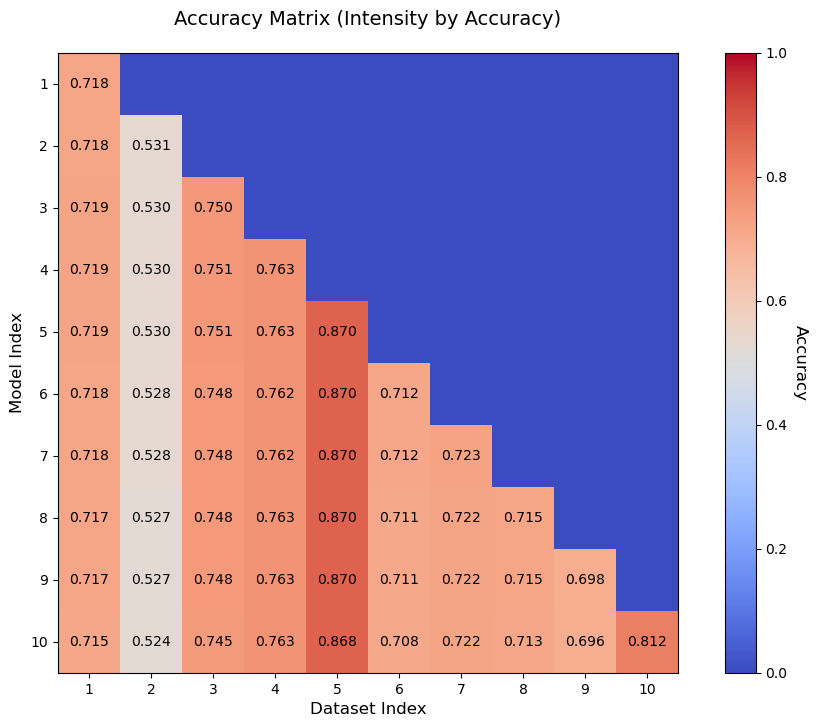

In [ ]:
# Plotting the accuracy matrix as a heatmap
accuracy_matrix = accuracies2
num_models = accuracy_matrix.shape[0]

plt.figure(figsize=(12, 8))
heatmap = plt.matshow(
    accuracy_matrix,
    cmap='coolwarm',  # Changed colormap for better contrast
    fignum=1,
    vmin=0,
    vmax=1.0
)

# Add color bar with accuracy label
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom", fontsize=12)

# Add annotations to each cell with the accuracy values
for i in range(num_models):
    for j in range(i + 1):  # Only show lower triangle values
        value = accuracy_matrix[i, j]
        plt.text(
            j, i, f"{value:.3f}",
            ha='center',
            va='center',
            color="white" if value < 0.5 else "black",  # Change text color for contrast
            fontsize=10
        )

# Adjust tick labels to start from 1 instead of 0
plt.xticks(ticks=range(num_models), labels=range(1, num_models + 1), fontsize=10)
plt.yticks(ticks=range(num_models), labels=range(1, num_models + 1), fontsize=10)

# Set axis labels
plt.xlabel("Dataset Index", fontsize=12)
plt.ylabel("Model Index", fontsize=12)
plt.title("Accuracy Matrix (Intensity by Accuracy)", fontsize=14, pad=20)

# Remove gridlines for a clean look
plt.gca().xaxis.tick_bottom()  # Move x-axis ticks to the bottom
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()